<a href="https://colab.research.google.com/github/MeyerTalon/Cars-DVM-Dataset-ViT/blob/main/Cars_DVM_Dataset_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets pandas torch transformers evaluate numpy matplotlib huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is inc

In [ ]:
import os
import shutil
import pandas as pd
import datasets
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from transformers import (
    AutoImageProcessor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer
)

In [ ]:
# We need to login as we'll upload our model and dataset to the hub.
notebook_login()

In [ ]:
# Removed sample_data folder that comes in Google Colab
!rm -rf ./sample_data

In [ ]:
# Download the car images zip file, unzip the file, then delete the zip file
!wget https://figshare.com/ndownloader/files/34792453
!unzip 34792453
!rm 34792453

# This zip file contains more car metadata which is not currently being used
# !wget https://figshare.com/ndownloader/files/34792483
# !unzip 34792483
# !rm 34792483
%ls

Streaming output truncated to the last 5000 lines.
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$205$$image_5.jpg  
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$30$$image_12.jpg  
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$30$$image_2.jpg  
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$66$$image_3.jpg  
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$66$$image_5.jpg  
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$66$$image_6.jpg  
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$73$$image_0.jpg  
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$73$$image_2.jpg  
  inflating: resized_DVM/Volvo/XC70/2014/Silver/Volvo$$XC70$$2014$$Silver$$96_17$$73$$image_6.jpg  
   creating: resized_DVM/Volvo/XC70/2014/Unlist

In [ ]:
# Create the split directories for training
dataset_dirs = ('./dataset/train', './dataset/test', './dataset/validation')
os.mkdir('./dataset')
for d in dataset_dirs:
    os.mkdir(d)

In [ ]:
# Create the sub folders withing the split directories
for root, dirs, files in os.walk('./resized_DVM'):
    for dir_name in dirs:
        for dataset_dir in dataset_dirs:
            new_dir_path = os.path.join(root, dir_name).replace('./resized_DVM', dataset_dir)
            os.mkdir(new_dir_path)

In [ ]:
# Move the images from the resived_DVM folder to the dataset folder with an
# 80% train 10% validation and 10% test split
total_count = 0
count = 0
for root, dirs, files in os.walk('./resized_DVM'):
  for file_name in files:
      current_file_path = os.path.join(root, file_name)
      if count == 8:
        # Move to test folder and increment count
        new_file_path = os.path.join(root, file_name).replace('./resized_DVM', './dataset/test')
        shutil.move(current_file_path, new_file_path)
        count += 1
      elif count == 9:
        # Move to validation folder and reset count
        new_file_path = os.path.join(root, file_name).replace('./resized_DVM', './dataset/validation')
        shutil.move(current_file_path, new_file_path)
        count = 0
      else:
        # Otherwise move file to train folder and increment count
        new_file_path = os.path.join(root, file_name).replace('./resized_DVM', './dataset/train')
        shutil.move(current_file_path, new_file_path)
        count += 1

      # Increment total file count
      total_count += 1

  # Only do the first 5,000 images (approx), the dataset library and Colab failed
  # with the entire dataset at 60,000 images
  if total_count >= 5000:
    break



In [ ]:
# Get rid of resized_DVM folder now that we have parsed them
# shutil.rmtree('./resized_DVM')
!rm -rf ./resized_DVM


In [ ]:
# Load the metadata as a pandas dataframe
# image_metadata = pd.read_csv('./Image_table.csv')
# image_metadata.rename(columns={' Image_name': 'file_name'}, inplace=True)
# image_metadata['car_name'] = image_metadata['file_name'].apply(lambda value: ' '.join(value[:value.index('_')].replace('$$', ' ').split()[:-1]))
# image_metadata.drop(columns=['Genmodel_ID', ' Image_ID', ' Predicted_viewpoint', ' Quality_check'], inplace=True)
# image_metadata.to_csv('./dataset/metadata.csv', index=False)
# print(image_metadata)

In [ ]:
file_names = []
car_names = []
for root, dirs, files in os.walk('./dataset'):
  for file in files:
    if file == '.DS_Store':
        continue
    file_names.append(os.path.join(root, file).replace('./dataset/', ''))
    car_names.append(' '.join(file[:file.index('_')].replace('$$', ' ').split()[:-1]))


metadata_df = pd.DataFrame({
    'file_name': file_names,
    'label': car_names
})

metadata_df.to_csv('./dataset/metadata.csv', index=False)
print(metadata_df)

                                              file_name  \
0     validation/MG/TF/2004/Purple/MG$$TF$$2004$$Pur...   
1     validation/MG/TF/2004/Blue/MG$$TF$$2004$$Blue$...   
2     validation/MG/TF/2004/Blue/MG$$TF$$2004$$Blue$...   
3     validation/MG/TF/2004/Blue/MG$$TF$$2004$$Blue$...   
4     validation/MG/TF/2004/Blue/MG$$TF$$2004$$Blue$...   
...                                                 ...   
5069  train/Subaru/Impreza/2008/Blue/Subaru$$Impreza...   
5070  train/Subaru/Impreza/2008/Blue/Subaru$$Impreza...   
5071  train/Subaru/Impreza/2008/Blue/Subaru$$Impreza...   
5072  train/Subaru/Impreza/2008/Blue/Subaru$$Impreza...   
5073  train/Subaru/Impreza/2008/Blue/Subaru$$Impreza...   

                         label  
0            MG TF 2004 Purple  
1              MG TF 2004 Blue  
2              MG TF 2004 Blue  
3              MG TF 2004 Blue  
4              MG TF 2004 Blue  
...                        ...  
5069  Subaru Impreza 2008 Blue  
5070  Subaru Impreza 2008 B

In [ ]:
dataset = datasets.load_dataset('imagefolder', data_dir='./dataset')
print(dataset)

Resolving data files:   0%|          | 0/4060 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/507 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/507 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4060
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 507
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 507
    })
})


In [ ]:
dataset.push_to_hub('TalonMeyer/dvm-cars-dataset-first-5k')
print("Pushed to HF!")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/4060 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/537 [00:00<?, ?B/s]

Pushed to HF!


In [ ]:
# Get the labels from the dataset
labels = dataset['train'].unique('label')
print(len(labels),labels)

100 ['Kia Rio 2006 Black', 'Kia Rio 2006 Blue', 'Kia Rio 2006 Red', 'Kia Rio 2006 Silver', 'Kia Rio 2011 Black', 'Kia Rio 2011 Blue', 'Kia Rio 2011 Red', 'Kia Rio 2011 Silver', 'Kia Rio 2011 Unlisted', 'Kia Rio 2011 White', 'Kia Rio 2012 Grey', 'Kia Rio 2015 Black', 'Kia Rio 2015 Blue', 'Kia Rio 2015 Grey', 'Kia Rio 2015 Red', 'Kia Rio 2015 Silver', 'Kia Rio 2015 Unlisted', 'Kia Rio 2015 White', 'Kia Rio 2015 Yellow', 'Kia Rio 2016 Black', 'Kia Rio 2016 Blue', 'Kia Rio 2016 Grey', 'Kia Rio 2016 Red', 'Kia Rio 2016 Silver', 'Kia Rio 2016 Unlisted', 'Kia Rio 2016 White', 'Kia Rio 2016 Yellow', 'Kia Rio 2019 Black', 'Kia Rio 2019 Blue', 'Kia Rio 2019 Brown', 'Kia Rio 2019 Grey', 'Kia Rio 2019 Red', 'Kia Rio 2019 Silver', 'Kia Rio 2019 White', 'Kia Rio 2019 Yellow', 'Kia Soul 2009 Beige', 'Kia Soul 2009 Black', 'Kia Soul 2009 Blue', 'Kia Soul 2009 Orange', 'Kia Soul 2009 Red', 'Kia Soul 2009 Silver', 'Kia Soul 2009 Unlisted', 'Kia Soul 2009 White', 'Kia Soul 2010 Black', 'Kia Soul 2010 Blu

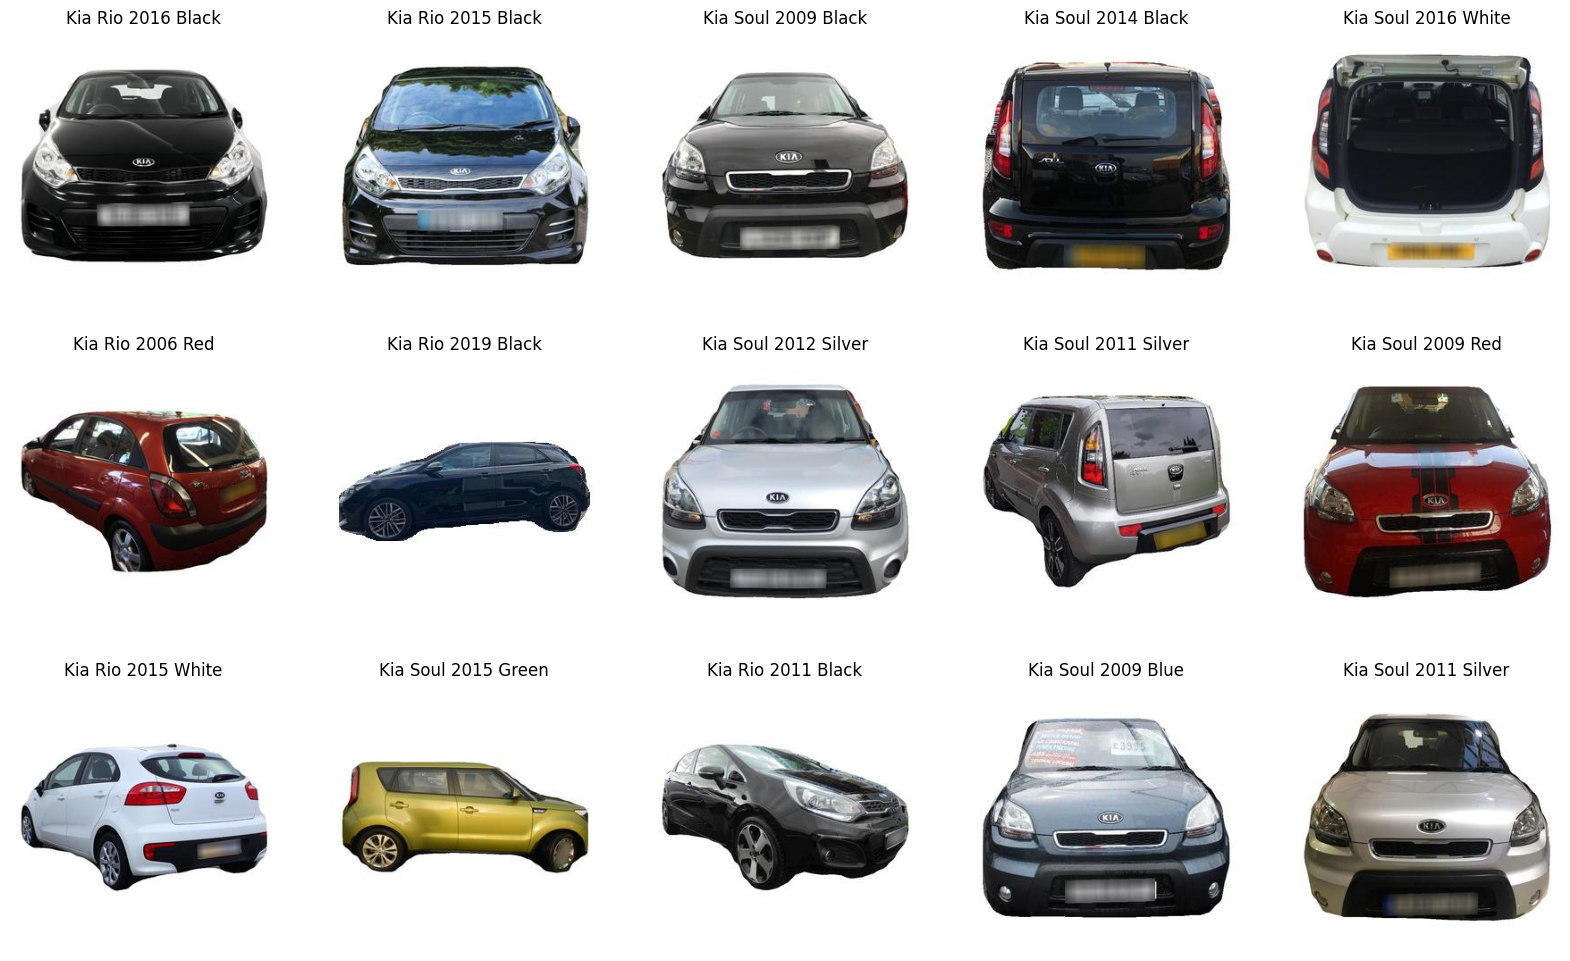

In [ ]:
# Show a sample of the dataset
def show_samples(ds, rows, cols):
  samples = ds.shuffle().select(np.arange(rows*cols))
  fig = plt.figure(figsize=(cols*4,rows*4))
  for i in range(rows*cols):
    img = samples[i]['image']
    label = samples[i]['label']
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

In [ ]:
label2id = {c: idx for idx, c in enumerate(labels)}
id2label = {idx: c for idx, c in enumerate(labels)}

In [ ]:
# Load the Google ViT processor from HF
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
# Define a transform function to transform our dataset using the processer we loaded
def transforms(batch):
  batch['image'] = [x.convert('RGB') for x in batch['image']]
  inputs = processor(batch['image'],return_tensors='pt')
  inputs['labels']=[label2id[y] for y in batch['label']]
  return inputs

# Processes our dataset to match the Google ViT architecture
processed_dataset = dataset.with_transform(transforms)

In [ ]:
# Create a collate function
def collate_fn(batch):
  return {
      'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      'labels': torch.tensor([x['labels'] for x in batch])
  }

In [ ]:
# Create a metrics function
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits,axis=1)
  score = accuracy.compute(predictions=predictions, references=labels)
  return score

In [ ]:
# Load the pretrained Google ViT
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

model

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Freeze all layers besides the new classifier layer
for name,p in model.named_parameters():
  if not name.startswith('classifier'):
    p.requires_grad = False

In [ ]:
# Check how many parameters are there in the model along with how many are actually going to be trained now.
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,875,556 | trainable_params = 76,900


In [ ]:
# Define my training arguments
training_args = TrainingArguments(
    output_dir='./dvm-cars-vit-first-5k',
    per_device_train_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    tokenizer=processor
)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
trainer.train()

TrainOutput(global_step=1255, training_loss=2.480602133701522, metrics={'train_runtime': 348.8828, 'train_samples_per_second': 57.498, 'train_steps_per_second': 3.597, 'total_flos': 1.7531674642644664e+18, 'train_loss': 2.480602133701522, 'epoch': 5.0})

In [ ]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 2.3711330890655518,
 'eval_accuracy': 0.4431137724550898,
 'eval_runtime': 7.0137,
 'eval_samples_per_second': 71.432,
 'eval_steps_per_second': 8.982,
 'epoch': 5.0}

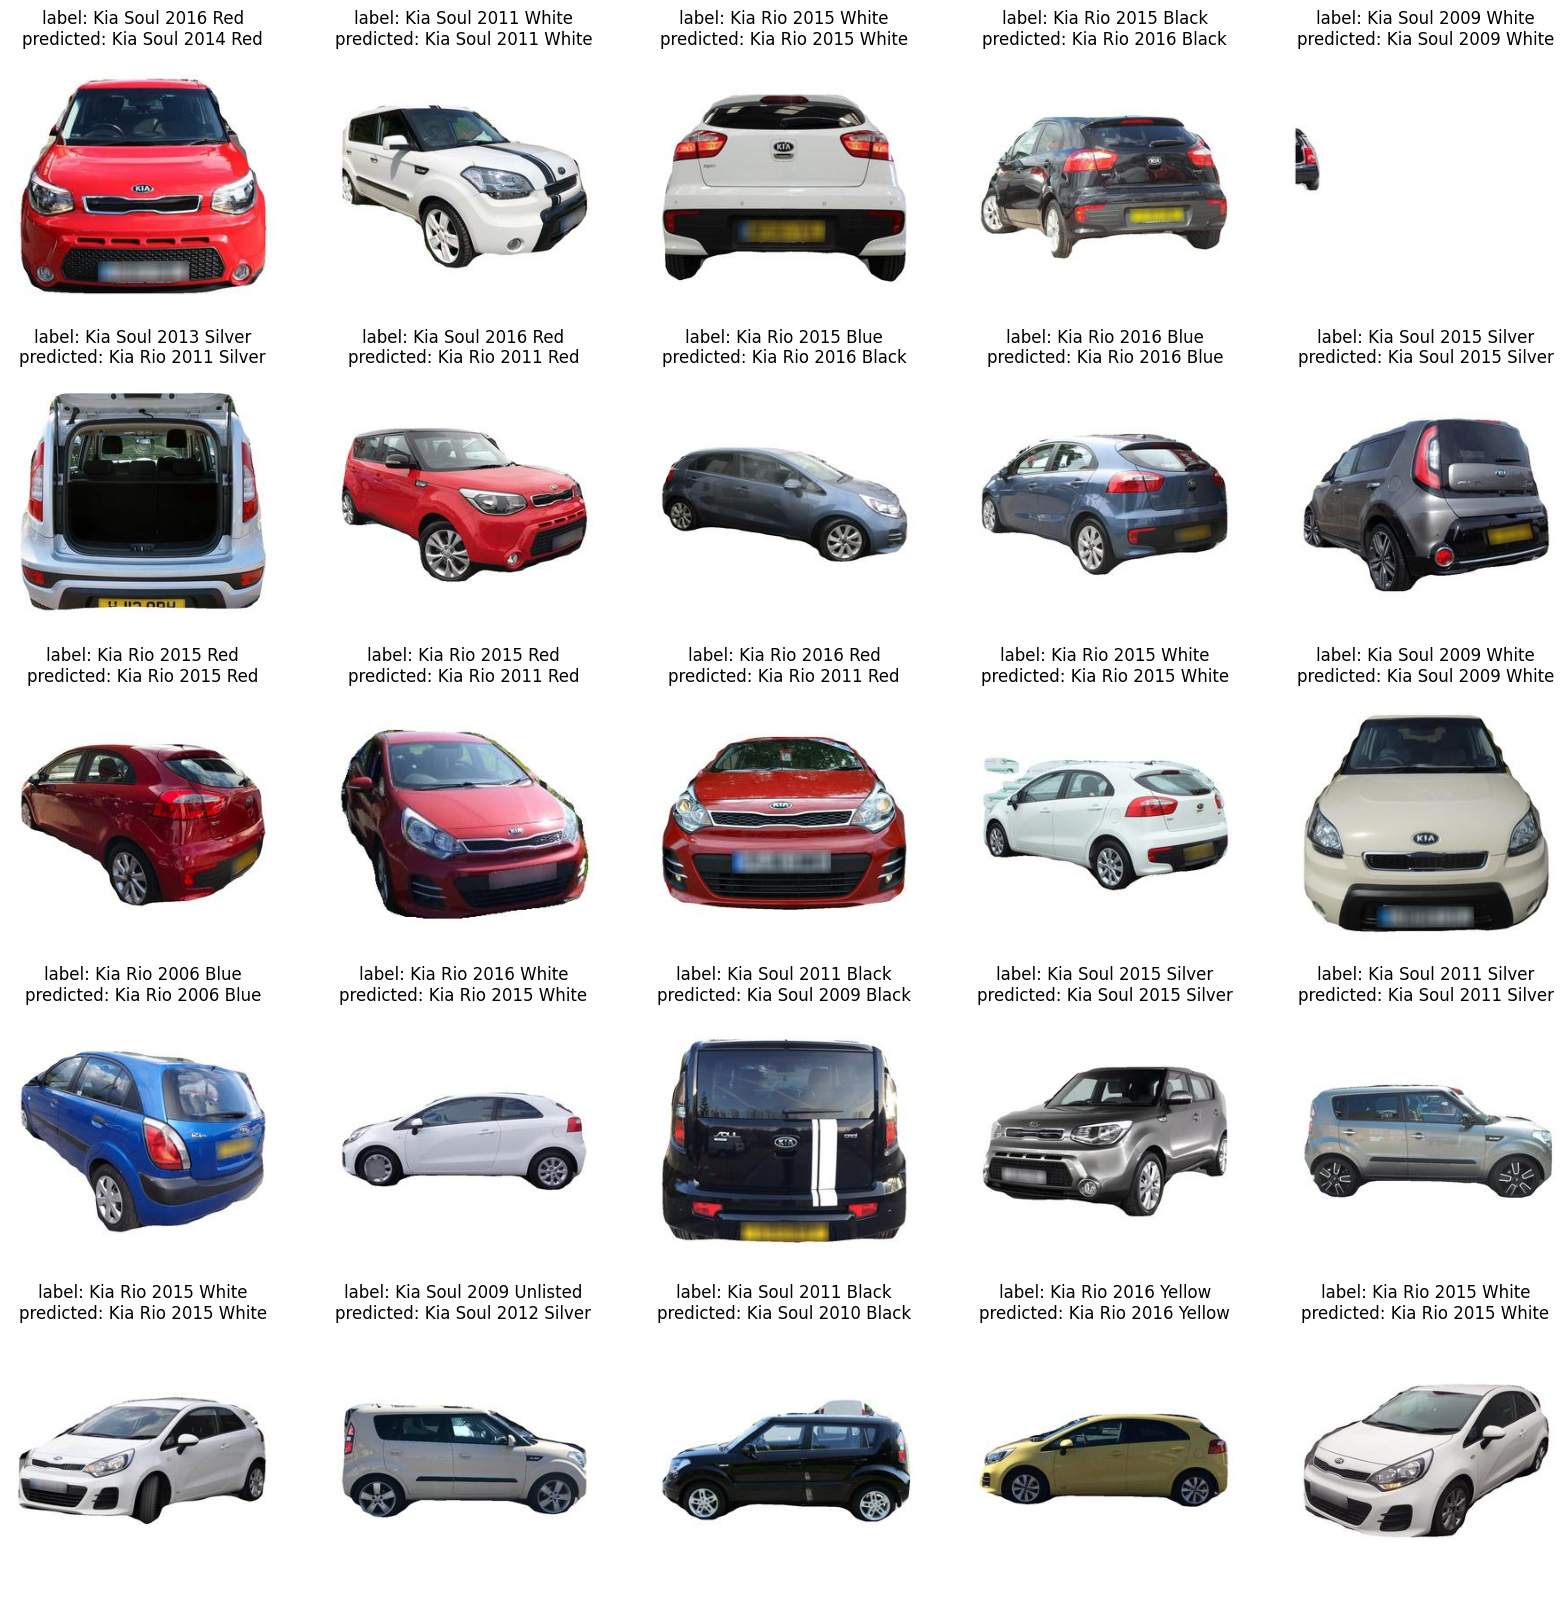

In [ ]:
def show_predictions(ds, rows, cols):
  samples = ds['test'].shuffle().select(np.arange(rows*cols))
  processed_samples = samples.with_transform(transforms)
  predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # predicted labels from logits
  fig = plt.figure(figsize=(cols*4,rows*4))
  for i in range(rows*cols):
    img = samples[i]['image']
    prediction = predictions[i]
    label = f'label: {samples[i]["label"]}\npredicted: {id2label[prediction]}'
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

show_predictions(dataset, rows=5,cols=5)

In [ ]:
kwargs = {
    'finetuned_from': model.config._name_or_path,
    'dataset': 'TalonMeyer/dvm-cars-dataset-first-5k',
    'tasks': 'image-classification',
    'tags': ['image-classification'],
}

In [ ]:
trainer.save_model()

In [ ]:
trainer.push_to_hub('TalonMeyer/dvm-cars-vit-first-5k', **kwargs)
print('Pushed to HF!')

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

events.out.tfevents.1725495408.5981fced46a1.897.0:   0%|          | 0.00/38.0k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1725495815.5981fced46a1.897.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Pushed to HF!
